<a href="https://colab.research.google.com/github/Lavyadev/deeplense/blob/main/common_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np
import os
from PIL import Image


In [42]:
import numpy as np

class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.images = []

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.endswith(".npy"):  # Only load .npy files
                    img_path = os.path.join(class_path, img_name)
                    self.images.append((img_path, label))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]


        image = np.load(img_path)


        image = np.squeeze(image)

        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        elif len(image.shape) == 3 and image.shape[0] == 1:
            image = image[0]


        image = Image.fromarray((image * 255).astype(np.uint8))

        if self.transform:
            image = self.transform(image)

        return image, label


In [52]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images
    transforms.RandomRotation(20),  # Rotate images by ±20 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random zoom
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to -1 to 1 range
])


In [44]:

from sklearn.model_selection import train_test_split

train_path = "/content/dataset/train"
full_dataset = LensDataset(train_path, transform=transform)


train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

print(f"New Training images: {len(train_dataset)}, New Validation images: {len(val_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training images: {len(train_dataset)}, Validation images: {len(val_dataset)}")



New Training images: 27000, New Validation images: 3000
Training images: 27000, Validation images: 3000


In [50]:
import torchvision.models as models
import torch.nn as nn

# Load a pretrained ResNet model
model = models.resnet18(pretrained=True)

# Modify the last layer for 3 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # Adjust for 3-class classification



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
 # Adam optimizer


In [53]:
import torch
import os

# Define checkpoint path
checkpoint_path = "/content/model_checkpoint.pth"

# Load checkpoint if available
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1  # Resume from next epoch
    train_losses = checkpoint["train_losses"]
    val_losses = checkpoint["val_losses"]
    print(f"Resuming training from epoch {start_epoch}...")

epochs = 10

for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Save checkpoint after every epoch
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses
    }, checkpoint_path)

print("Training Complete! 🚀")



Epoch 1/10, Train Loss: 1.0415, Val Loss: 0.8743
Epoch 2/10, Train Loss: 0.7522, Val Loss: 0.6989
Epoch 3/10, Train Loss: 0.6101, Val Loss: 0.5521
Epoch 4/10, Train Loss: 0.5305, Val Loss: 0.5301
Epoch 5/10, Train Loss: 0.4865, Val Loss: 0.4644
Epoch 6/10, Train Loss: 0.4439, Val Loss: 0.4830
Epoch 7/10, Train Loss: 0.4144, Val Loss: 0.4070
Epoch 8/10, Train Loss: 0.3910, Val Loss: 0.3685
Epoch 9/10, Train Loss: 0.3636, Val Loss: 0.3568
Epoch 10/10, Train Loss: 0.3451, Val Loss: 0.3259
Training Complete! 🚀


Validation AUC Score: 0.9689


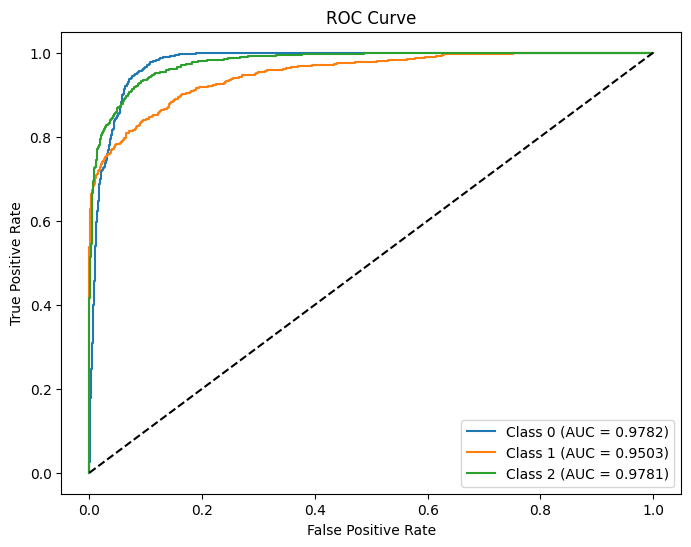

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import torch.nn.functional as F

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)

            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)


    auc_score = roc_auc_score(all_labels, all_preds, multi_class='ovr')
    print(f"Validation AUC Score: {auc_score:.4f}")


    plt.figure(figsize=(8, 6))
    for i in range(all_preds.shape[1]):
        fpr, tpr, _ = roc_curve(all_labels == i, all_preds[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc_score(all_labels == i, all_preds[:, i]):.4f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


evaluate_model(model, val_loader, device)


In [57]:
torch.save(model.state_dict(), "lens_classifier.pth")
print("Model saved successfully")


Model saved successfully
